In [12]:
# Use this Block only for setting up recording

# Import PAUDIO base IP
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")
pAudio = base.audio

# Select HP MIC as input for our audio data
pAudio.select_microphone()

In [13]:
# Record audio file from microphone
pAudio.record(30)
pAudio.save("burn_house_real.wav")

In [1]:
# We will read from this file for FFT
file_str = "/home/xilinx/jupyter_notebooks/pynq-182/burn_house_real.wav"

In [2]:
# Imports for Matplotlib
%matplotlib notebook
import struct
import wave
import numpy as np
import matplotlib
from scipy.fftpack import fft
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [3]:
# Set up Arduino Overlay for GPIO Control
from pynq.overlays.base import BaseOverlay
from pynq.lib.arduino import Arduino_IO


base = BaseOverlay("base.bit")

In [4]:
# Set up GPIO Pins
green = Arduino_IO(base.ARDUINO, 14, "out")
red = Arduino_IO(base.ARDUINO, 15, "out")
blue = Arduino_IO(base.ARDUINO, 16, "out")

In [5]:
# Import wav file and extract required variables
wav_path = file_str  #i6???

with wave.open(wav_path, 'r') as wav_file:
    raw_frames = wav_file.readframes(-1)
    num_frames = wav_file.getnframes()
    num_channels = wav_file.getnchannels()
    sample_rate = wav_file.getframerate()
    sample_width = wav_file.getsampwidth()

temp_buffer = np.empty((num_frames, num_channels, 4), dtype=np.uint8)
raw_bytes = np.frombuffer(raw_frames, dtype=np.uint8)
temp_buffer[:, :, :sample_width] = raw_bytes.reshape(-1, num_channels, 
                                                    sample_width)
temp_buffer[:, :, sample_width:] = \
    (temp_buffer[:, :, sample_width-1:sample_width] >> 7) * 255
frames = temp_buffer.view('<i4').reshape(temp_buffer.shape[:-1])
data = frames[:, 0]

print("Data Length:", len(data))
print("Number of frames:", num_frames)
print("Split:", len(raw_frames)/num_frames)
print("Sample Rate:", sample_rate)
print("Frames/Sample:", num_frames/sample_rate)

# Set number of color updates per second
freq_read_per_sec = 5

Data Length: 1440000
Number of frames: 1440000
Split: 6.0
Sample Rate: 48000
Frames/Sample: 30.0


In [6]:
# Test looping to check for correct frequency outputs/number of frequency readings
for i in range(len(data)//(sample_rate//freq_read_per_sec)):
    curr = data[i*(sample_rate//freq_read_per_sec):(i+1)*(sample_rate//freq_read_per_sec)]
    w = np.fft.fft(curr)
    freqs = np.fft.fftfreq(len(w))

    idx = np.argmax(np.abs(w))
    freq = freqs[idx]
    freq_in_hertz = abs(freq * sample_rate)
    print(freq_in_hertz)


10.0
20.0
40.0
15.0
0.0
2675.0
2580.0
2580.0
2295.0
2605.0
1030.0
1030.0
2535.0
2575.0
2600.0
2310.0
430.0
515.0
1030.0
2550.0
655.0
580.0
780.0
3550.0
1295.0
520.0
1050.0
770.0
650.0
645.0
645.0
580.0
575.0
950.0
580.0
765.0
1795.0
1030.0
495.0
645.0
2600.0
510.0
650.0
1295.0
515.0
1425.0
640.0
645.0
505.0
650.0
780.0
2795.0
580.0
775.0
2275.0
1925.0
640.0
570.0
580.0
1310.0
2040.0
2545.0
2605.0
2610.0
2610.0
1955.0
2170.0
870.0
1745.0
2540.0
1965.0
1965.0
2545.0
4085.0
1930.0
1920.0
1925.0
1955.0
1955.0
1740.0
870.0
875.0
2540.0
1965.0
1965.0
1555.0
3105.0
2590.0
2060.0
2305.0
1955.0
1955.0
2330.0
2340.0
1750.0
2540.0
1965.0
2280.0
3570.0
2555.0
2345.0
1920.0
1930.0
1955.0
1955.0
1940.0
875.0
875.0
2540.0
2795.0
2710.0
2720.0
2605.0
865.0
2550.0
1030.0
1795.0
6630.0
2110.0
2260.0
870.0
645.0
2580.0
2580.0
2470.0
3595.0
6680.0
3845.0
3820.0
1285.0
2030.0
2030.0
780.0
2735.0
2295.0
2595.0
2785.0
580.0
2650.0
6460.0
855.0
1760.0
775.0
785.0
780.0
2300.0
3735.0
765.0
6515.0
1020.0


<IPython.core.display.Javascript object>


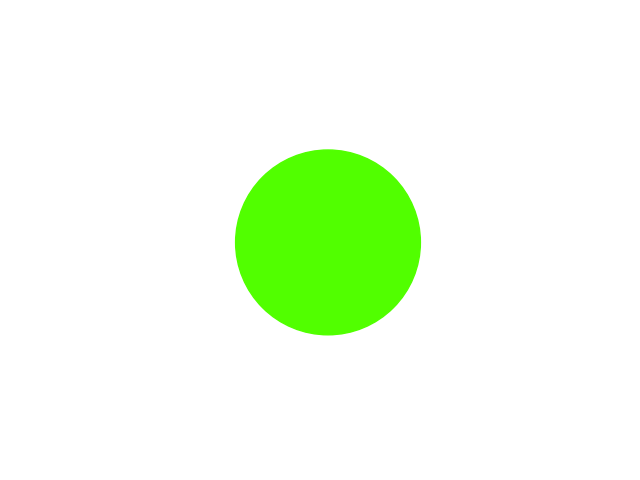

In [7]:
# Demonstration of FFT with Matplotlib visualization

# Normalize our frequencies to proper range
norm = matplotlib.colors.Normalize(vmin=0, vmax=3000, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.gist_rainbow)

# Set up graph
fig = plt.figure() 
ax = plt.axes(xlim=(-10, 10), ylim=(-10, 10)) 
ax.set_aspect('equal')
circle = plt.Circle((0,0), 5, color='b')
ax.add_patch(circle)
plt.axis('off')

# Function to update circle color
def updateCircleColor(circle, color):
    circle.set_color(color)

    if (color[0] > color[1] and color[0] > color[2]):
        if (color[2] > 0.75):
            green.write(0)
            blue.write(1)
            red.write(1)
        else:
            green.write(0)
            blue.write(0)
            red.write(1)
        
    elif (color[1] >= color[0] and color[1] >= color[3]):
        if (color[2] > 0.75):
            green.write(1)
            blue.write(1)
            red.write(0)
        else:
            green.write(1)
            blue.write(0)
            red.write(0)
        
    elif (color[2] >= color[0] and color[2] > color[1]):
        if (color[0] > 0.75):
            green.write(0)
            blue.write(1)
            red.write(1)
        else:
            green.write(0)
            blue.write(1)
            red.write(0)
    
    return circle,

# Main function responsible for animating Matplotlib graph
def main(i, circle):
    #data = np.frombuffer(resized_frames, dtype=np.int8, count=441, offset=i)
    curr = data[i*(sample_rate//freq_read_per_sec):(i+1)*(sample_rate//freq_read_per_sec)]
    w = np.fft.fft(curr)
    freqs = np.fft.fftfreq(len(w))

    idx = np.argmax(np.abs(w))
    freq = freqs[idx]
    freq_in_hertz = abs(freq * sample_rate)
    
    #peak = np.average(np.abs(curr))*2
    bars="#"#*int(50*peak/2**16)

    color = mapper.to_rgba(freq_in_hertz)
    print("Peak frequency: %d Hz | Color: %.4f %.4f %.4f %.4f | Volume %s | i %d"
          %(freq_in_hertz, mapper.to_rgba(freq_in_hertz)[0], mapper.to_rgba(freq_in_hertz)[1], 
            mapper.to_rgba(freq_in_hertz)[2], mapper.to_rgba(freq_in_hertz)[3], bars, i))
    return updateCircleColor(circle, color)

# Run animation loop to update color of circle
anim = animation.FuncAnimation(fig, main, fargs=(circle, ), blit=True, interval=110)
plt.show()